In [ ]:
import warnings

warnings.filterwarnings('ignore')

In [1]:
% load_ext autoreload
% autoreload 2

# Getting Started
Let's walk through an example application of Geometricus in machine learning using a dataset of
human MAP kinases, divided into three classes - JNK, Erk, and p38 kinases. This dataset was generated from the [Kinase-Ligand Interaction Fingerprints and Structures database (KLIFS)](https://klifs.vu-compmedchem.nl/index.php) (Raw table [here](../../example_data/MAPK_KLIFS.tsv)).

In [2]:
import pandas as pnd
from time import time

url = "https://raw.githubusercontent.com/TurtleTools/geometricus/master/example_data/MAPK_KLIFS.tsv"
mapk_df = pnd.read_csv(url, sep="\t")

mapk_pdb_id_to_class = {}
for pdb_id, chain, class_name in list(zip(mapk_df["PDB"], mapk_df["CHAIN"], mapk_df["CLASS"])):
    mapk_pdb_id_to_class[(pdb_id, chain)] = class_name
len(mapk_pdb_id_to_class)

527

So now we have a list of (PDB ID, chain) pairs, each associated with a class

In [3]:
X_names = list(mapk_pdb_id_to_class.keys())
class_mapping = {"JNK": 0, "Erk": 1, "p38": 2}
y = [class_mapping[mapk_pdb_id_to_class[k]] for k in X_names]

Below we fetch and parse each protein as a ProDy AtomGroup object. This takes a while (around 15 mins) since it downloads via FTP from RCSB.

In [4]:
import prody as pd

start_time = time()
pdbs = []
keys = []
for i, (pdb_id, chain) in enumerate(X_names):
    if i > 0 and i % 50 == 0:
        print(f"{i} proteins fetched in {(time() - start_time):.2f} seconds")
    keys.append(f"{pdb_id}_{chain}")
    pdbs.append(pd.parsePDB(pdb_id, chain=chain))

50 proteins fetched in 1.47 seconds
100 proteins fetched in 3.15 seconds
150 proteins fetched in 5.13 seconds
200 proteins fetched in 7.00 seconds
250 proteins fetched in 8.75 seconds
300 proteins fetched in 10.23 seconds
350 proteins fetched in 11.61 seconds
400 proteins fetched in 12.99 seconds
450 proteins fetched in 14.71 seconds
500 proteins fetched in 16.51 seconds


## Structural fragmentation
We consider two different ways of dividing a protein with $l$ residues into structural fragments, a $k$-mer-based approach and a radius-based approach. For each structural fragment, multiple rotation and translation-invariant moments can be calculated. While the $k$-mer based approach is effective in describing structural fragments that are sequential in nature, such as $\alpha$-helices and loops, the radius-based approach can capture long-range structural contacts as seen in $\beta$-sheets, as well as distinct interaction patterns in space, as found in enzyme active sites.

Moment invariants can be calculated using the `geometricus.MomentInvariants` class. This class has many constructors, such as the `from_prody_atomgroup` below. This can be replaced by `from_pdb_file` to load a protein from a file or even `from_pdb_id` to download from RCSB via FTP.

This is the point where you decide the type and size of structural fragmentation to use. The options are:

* KMER - each residue is taken as the center of a kmer of length `split_size`, ends are included but shorter
* RADIUS - overlapping spheres of radius `split_size`
* RADIUS_UPSAMPLE - upsamples backbone atoms before taking overlapping spheres.
* KMER_CUT - same as kmer but ends are not included, only fragments of length `split_size` are kept
* ALLMER - adds kmers of different lengths (`split_size - 5` to `split_size + 5`) to take into account deletions/insertions that don't change the shape

Below we use `SplitType.KMER` with a `split_size` (i.e. kmer size) of 16 and `SplitType.RADIUS` with a `split_size` (i.e. radius) of 10.

`geometricus.MomentType` lists the available moment invariants. By default $O_3$, $O_4$, $O_5$, and $F$ are calculated. This can be changed using the `moment_types` argument in any of the `MomentInvariants` constructors.

In [5]:
from geometricus import MultipleMomentInvariants, SplitInfo, SplitType

invariants_kmer = []
invariants_radius = []

start_time = time()
for i, key in enumerate(keys):
    if i > 0 and i % 50 == 0:
        print(f"{i} proteins in {(time() - start_time):.2f} seconds")
    invariants_kmer.append(
        MultipleMomentInvariants.from_prody_atomgroup(key, pdbs[i], split_infos=[SplitInfo(SplitType.KMER, 16)],
                                                      moment_types=["O_3", "O_4", "O_5", "F"]))
    invariants_radius.append(
        MultipleMomentInvariants.from_prody_atomgroup(key, pdbs[i], split_infos=[SplitInfo(SplitType.RADIUS, 10)],
                                                      moment_types=["O_3", "O_4", "O_5", "F"]))

50 proteins in 2.60 seconds
100 proteins in 4.21 seconds
150 proteins in 5.90 seconds
200 proteins in 7.63 seconds
250 proteins in 9.24 seconds
300 proteins in 10.87 seconds
350 proteins in 12.57 seconds
400 proteins in 14.18 seconds
450 proteins in 15.93 seconds
500 proteins in 17.55 seconds


Since we expect these proteins to be structurally quite similar and are more interested in small changes, we set the resolution quite high, to 2.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from geometricus import Geometricus

start_time = time()
kmer_class = Geometricus.from_invariants(invariants_kmer, resolution=1.)
radius_class = Geometricus.from_invariants(invariants_radius, resolution=1.)
print(f"Generated shapemers in {(time() - start_time):.2f} seconds")

Generated embeddings in 0.63 seconds


In [15]:
kmer_count_matrix = kmer_class.get_count_matrix()
radius_count_matrix = radius_class.get_count_matrix()
kmer_count_matrix.shape, radius_count_matrix.shape

((527, 263), (527, 246))

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


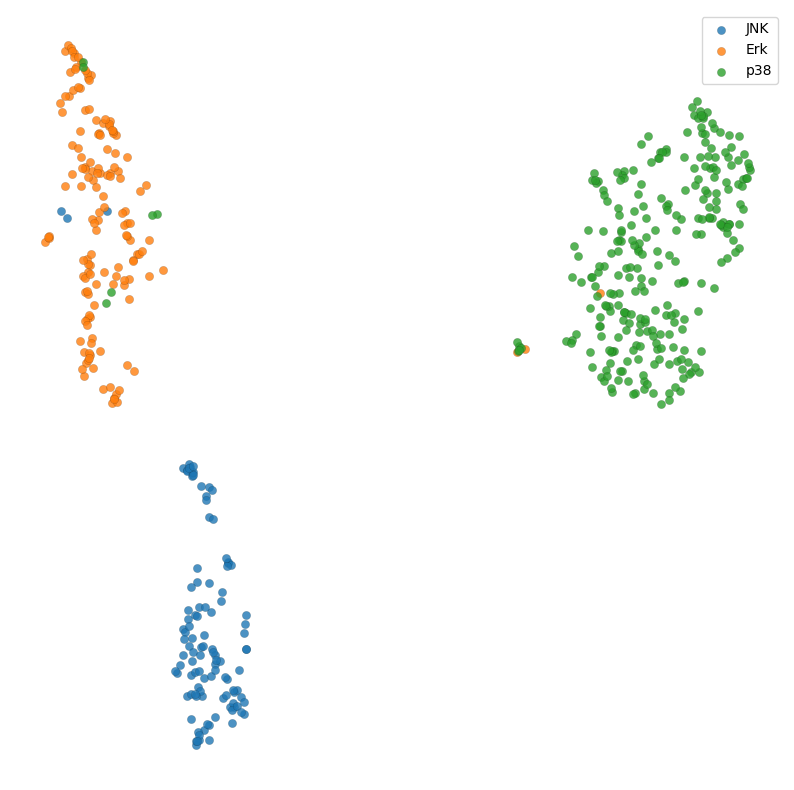

In [8]:
import umap

reducer = umap.UMAP(metric="cosine", n_components=2)
reduced = reducer.fit_transform(np.hstack((kmer_count_matrix, radius_count_matrix)))

class_names = ["JNK", "Erk", "p38"]
colors = ["red", "green", "blue"]
plt.figure(figsize=(10, 10))
for i in range(3):
    indices = np.where(np.array(y) == i)[0]
    plt.scatter(reduced[indices, 0],
                reduced[indices, 1],
                label=class_names[i], edgecolor="black", linewidth=0.1, alpha=0.8)
plt.axis("off")
plt.legend();

### Embedding for Supervised Learning
Supervised learning, be it classification or regression, requires some form of training and test set separation.
Below, the shape-mers used for embedding are calculated from the training set (using the kmer approach) and only those shape-mers are counted in the test proteins.

In [9]:
from sklearn.model_selection import train_test_split

X_train_names, X_test_names, y_train, y_test = train_test_split(keys, y, test_size=0.3)
_, train_shapemers = kmer_class.map_shapemers_to_indices(protein_keys=X_train_names)
X_train = kmer_class.get_count_matrix(X_train_names, shapemer_keys=train_shapemers)
X_test = kmer_class.get_count_matrix(X_test_names, shapemer_keys=train_shapemers)

For this simple problem, a decision tree classifier is more than enough to obtain good accuracy.

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

clf = DecisionTreeClassifier(random_state=42, max_depth=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, labels=[0, 1, 2], target_names=class_names))

              precision    recall  f1-score   support

         JNK       0.97      0.94      0.95        33
         Erk       0.97      0.95      0.96        39
         p38       0.97      0.99      0.98        87

    accuracy                           0.97       159
   macro avg       0.97      0.96      0.96       159
weighted avg       0.97      0.97      0.97       159



## Finding predictive residues and structural fragments

Since each shape-mer can be mapped back to the residues it describes, it's easy to use Geometricus to determine predictive or functionally relevant residues and structural regions from a trained predictor (or from loadings generated from a method such as PCA). Such insights can be directly be applied to select candidate residues for mutational studies or used in directed evolution techniques to engineer proteins and enzymes with desired properties.

By inspecting the decision tree created above, it becomes clear that some shape-mers are present multiple times across a protein and the number of times differs across classes.

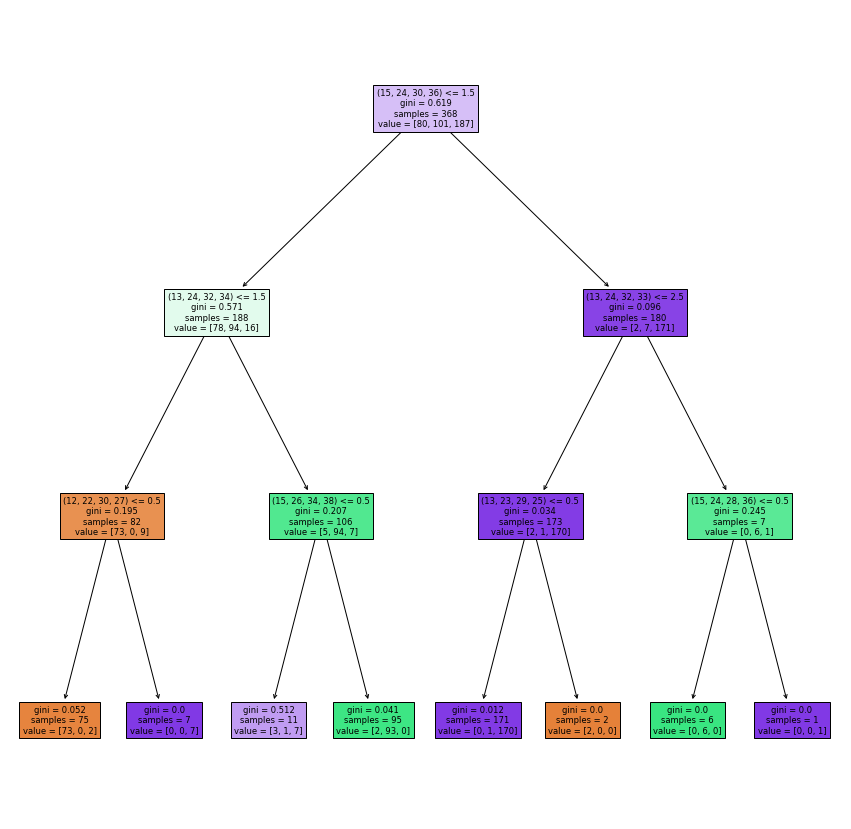

In [28]:
from sklearn.tree import plot_tree

fig, ax = plt.subplots(1, figsize=(15, 15))
plot_tree(clf, filled=True, ax=ax, feature_names=train_shapemers);

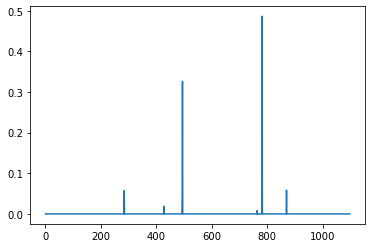

In [29]:
plt.plot(clf.feature_importances_)
predictive_feature_indices = np.argsort(clf.feature_importances_)[::-1][:6]

We can map back to the residues described by a shape-mer using the `map_shapemer_to_residues` function which returns a dictionary mapping each protein to the corresponding residue indices of the shape-mer within that protein, if it exists.

In [30]:
shapemer = train_shapemers[predictive_feature_indices[1]]
residue_indices = kmer_class.map_shapemer_to_residues(shapemer)
print("Shape-mer:", shapemer, "Number of proteins with shape-mer:", len(residue_indices))
print()
print("Residue indices per protein (for 10 proteins):")
for i, key in enumerate(residue_indices):
    if i > 10:
        break
    print(key, residue_indices[key])

Shape-mer: (13, 24, 32, 34) Number of proteins with shape-mer: 507

Residue indices per protein (for 10 proteins):
('3o2m', 'A') {234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249}
('3o2m', 'B') {234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249}
('4eh8', 'A') {231, 232, 233, 234, 235, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119}
('4eh2', 'A') {230, 231, 232, 233, 234, 235, 236, 221, 222, 223, 224, 225, 226, 227, 228, 229, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119}
('4eh7', 'A') {224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 221, 222, 223}
('4eh5', 'A') {224, 225, 226, 227, 228, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223}
('4dli', 'A') {224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 218, 219, 220, 221, 222, 223}
('4eh3', 'A') {231, 232, 233, 234, 235, 236, 

These residue indices can then be visualized on a protein structure using molecule visualization software such as PyMol. Comparing the same location in proteins which don't have this shape-mer can also be informative.